# 2. Photometric redshifts of galaxies

In [1]:
import numpy as np
from astropy.table import Table
from sklearn.linear_model import LinearRegression, Ridge, Lasso
#from scipy.optimize import minimize
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline

a) The early work on photometric redshifts was done using linear regression. Design a regression
estimator using either ridge, LASSO or linear regression to predict photometric redshifts, make
sure to justify all your choices you make. Use the whole of file A for training and aim to obtain
E(θ) < 0.01 as training error. 

What we have been using in class for this is the astroML or sklearn libraries (astroML doesn't have ridge or lasso), specifically LinearRegression, Ridge and Lasso.

In [2]:
# Load data
data_train = Table.read('Tables/PhotoZfileA.vot', format='votable')
data_test = Table.read('Tables/PhotoZfileB.vot', format='votable')
#data_test = Table.read('Tables/PhotoZfileA.vot', format='votable')
#data_train = Table.read('Tables/PhotoZfileB.vot', format='votable')

data_train.pprint(max_width=-1)
data_test.pprint(max_width=-1)
# Create data arrays for the regression
mag_r_train = np.array(data_train['mag_r'])
ug_train = np.array(data_train['u-g'])
gr_train = np.array(data_train['g-r'])
ri_train = np.array(data_train['r-i'])
iz_train = np.array(data_train['i-z'])
z_spec_train = np.array(data_train['z_spec'])

M_train = np.column_stack((ug_train, gr_train, ri_train, iz_train))

# And for the testing (problem b)
mag_r_test = np.array(data_test['mag_r'])
ug_test = np.array(data_test['u-g'])
gr_test = np.array(data_test['g-r'])
ri_test = np.array(data_test['r-i'])
iz_test = np.array(data_test['i-z'])
z_spec_test = np.array(data_test['z_spec'])

M_test = np.column_stack((ug_test, gr_test, ri_test, iz_test))

Counter       mag_r               u-g                g-r                 r-i                 i-z                z_spec      
------- ------------------ ------------------ ------------------ ------------------- ------------------- -------------------
      1 18.914286000000001 2.0729009999999999           1.386738 0.48228799999999999             0.27248            0.309728
      2 19.394960000000001           1.544794           1.557312 0.54168099999999997 0.41847000000000001 0.33647899999999997
      3          19.886253 1.0283979999999999           1.764324 0.67224899999999999 0.37468099999999999 0.40649999999999997
      4 17.561858999999998 2.1663969999999999           1.304127            0.428728 0.30382500000000001 0.19248499999999999
      5 18.495819000000001 1.3594569999999999 1.7209909999999999 0.52132400000000001 0.36005399999999999 0.31990400000000002
      6 17.668627000000001 2.0352060000000001 1.4620420000000001 0.44082100000000002 0.27839700000000001 0.23400599999999999


In [3]:
def do_regression(model, M, y, modelst='none', alpha=0.):
    """
    This function fits x-data M and y-data y using 'model' as a regression model. 
    It calculates the value for the error E_theta as defined in the problemset. 
    
    """
    
    # the higher z, the less accurate: less weight on higher zs:
    #weights = 1./y # this does decrease the linear error a tiny tiny bit...
    # the higher magr, the less accurate: less weight on higher mags:
    #weights = 1./(10**(-2.5*data_train['mag_r']))
    #weights = y/(1+y)
    
    # Fitting the model
    #res = model.fit(M,y, sample_weight=weights)
    res = model.fit(M,y)
    # Calculating the predicted values of y given the model (with parameters theta) for given data M
    ypred = model.predict(M)
    # Calculating the error from the problem set
    E_theta = np.median( np.abs( (y-ypred)/(1+y) ) )

    # Put the intercept and rest of the coefficients into one array
    c = [res.intercept_]
    [c.append(co) for co in res.coef_]
    c = np.array(c)
    
    # Calculate the least squares error thing (the thing that is actually minimized by the model)
    corr = 0.
    if model == 'ridge':
        corr = alpha * np.sum( (c**2) )
    elif model == 'lasso':
        corr = alpha * np.sum( (np.abs(c)) )
    E_lsq = np.sum( (y - ypred)**2 ) + corr 
    
    # Plotting the residuals vs the redshift
    residuals = ypred - y
    plt.scatter(y, residuals/y, label=str(model), alpha=0.01, marker='.')
    plt.ylabel('(z_spec,pred-z_spec)/z_spec')
    plt.xlabel('z_spec')
    plt.ylim(-0.4, 0.4)
    plt.xlim(0.15,0.7)
    print """Best-fit model is:\n z = {0:.3f}+ {1:.3f} (u-g) + {2:.3f} (g-r) + {3:.3f} (r-i) + {4:.3f} (i-z)""".format(c[0], c[1], c[2], c[3], c[4])
    print "E_theta =", E_theta, 'E_lsq =', E_lsq
    #return res
    return model

LinearRegression
Best-fit model is:
 z = -0.218+ -0.027 (u-g) + 0.115 (g-r) + 0.674 (r-i) + 0.007 (i-z)
E_theta = 0.0151055927011 E_lsq = 132.89829829

Ridge
Best-fit model is:
 z = -0.218+ -0.027 (u-g) + 0.115 (g-r) + 0.674 (r-i) + 0.007 (i-z)
E_theta = 0.0151058944027 E_lsq = 132.898301486

Lasso
Best-fit model is:
 z = -0.205+ -0.021 (u-g) + 0.106 (g-r) + 0.662 (r-i) + 0.000 (i-z)
E_theta = 0.0155114873155 E_lsq = 133.871372819


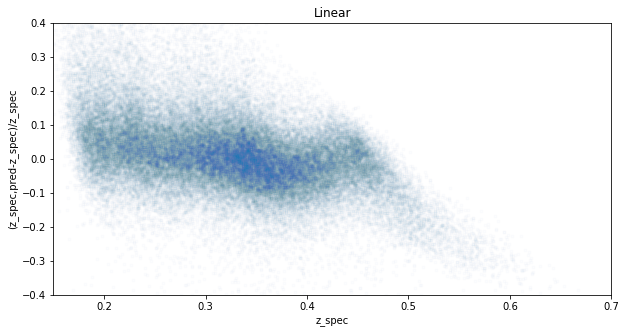

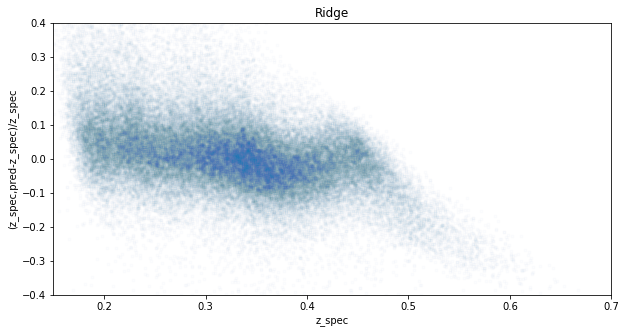

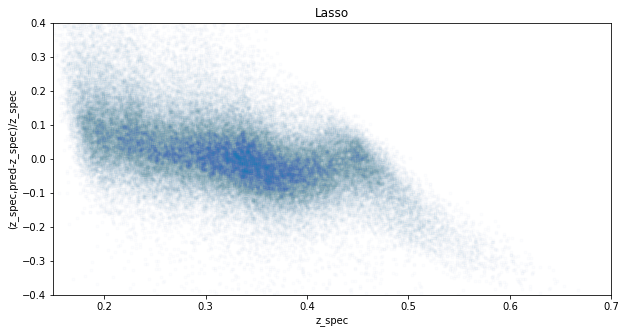

In [4]:
# What can we apply as weights? We don't know how accurately everything was determined...
# probably: the higher the redshift, the less precise... but don't know about that...

print 'LinearRegression'
plt.figure(figsize=(10,5))
plt.title('Linear')
mod_lin = do_regression(LinearRegression(fit_intercept=True), M_train, z_spec_train)

print 
print 'Ridge'
alpha = 1e-4
plt.figure(figsize=(10,5))
plt.title('Ridge')
mod_ridge = do_regression(Ridge(alpha, fit_intercept=True, normalize=True), 
                          M_train, z_spec_train, 'ridge', alpha)
#print res_ridge.n_iter_

print 
print 'Lasso'
alpha = 1e-5
maxiter = 1e7
plt.figure(figsize=(10,5))
plt.title('Lasso')
mod_lasso = do_regression(Lasso(alpha, fit_intercept=True, normalize=True, max_iter=maxiter), 
              M_train, z_spec_train, 'lasso', alpha)
#print res_lasso.n_iter_

I have to conclude that it is not possible to reduce E_theta to < 0.01 as a training error. I also used a lot more methods than the ones from sklearn, but I don't think we need them for this assignment as we never discussed anything else. Also, the results of my methods weren't better than this result.  

c) Explain why the error estimated on the training sample is not a reliable estimate of the generalisation error of an estimator. Use file B to quantify the generalisation error of the estimator you derived in problem b. 

In [5]:
def generr(mod, M, y):
    ypred = mod.predict(M)
    etheta = np.median( np.abs( (y-ypred)/(1+y) ) )
    return etheta

print 'Linear "generalisation error" =', generr(mod_lin, M_test, z_spec_test)
print
print 'Ridge "generalisation error" =', generr(mod_ridge, M_test, z_spec_test)
print 
print 'Lasso "generalisation error" =', generr(mod_lasso, M_test, z_spec_test)

# Weird: these errors are smaller than the errors above!!

Linear "generalisation error" = 0.01521648743

Ridge "generalisation error" = 0.0152149266448

Lasso "generalisation error" = 0.0156517903465


d) Implement a photo-z estimator using the method of your choice from any of the regression methods
discussed in the course, excluding the linear regression methods, e.g. k-nearest neighbours,
random forests, neural networks, boosting methods, but aim to get a lower generalisation error
than your method derived in problem b. 

In [6]:
# k-nearest neighbors

# Works only well in Guada's code because of the mag: but this still has a high test error
#M_train = np.column_stack((mag_r_train, gr_train, ri_train, iz_train))
#M_test = np.column_stack((mag_r_test, gr_test, ri_test, iz_test))


from sklearn.neighbors import KNeighborsRegressor

k = 3
knn = KNeighborsRegressor(k)

res_train = knn.fit(M_train, z_spec_train)
z_pred_train = res_train.predict(M_train)
etheta_train = np.median( np.abs( (z_spec_train-z_pred_train)/(1+z_spec_train) ) )
print etheta_train

z_pred_test = res_train.predict(M_test)
etheta_test = np.median( np.abs( (z_spec_test-z_pred_test)/(1+z_spec_test) ) )
print etheta_test

0.00989919336545
0.0141778144542


In [15]:
# k-nearest neighbors with adaboost:

from sklearn.ensemble import AdaBoostRegressor
num = 3
regr = AdaBoostRegressor(KNeighborsRegressor(num), n_estimators=5)
regres = regr.fit(M_train, z_spec_train)
z_pred_train = regres.predict(M_train)

etheta_train = np.median( np.abs( (z_spec_train-z_pred_train)/(1+z_spec_train) ) )
print etheta_train

z_pred_test = regres.predict(M_test)
etheta_test = np.median( np.abs( (z_spec_test-z_pred_test)/(1+z_spec_test) ) )
print etheta_test

# Find: increasing the number of estimators slightly increases the result for E_theta... 
# So not that good at all... Also there is no less discrepancy between train and test
# with 100 estimators (0.0107 vs 0.0158) as compared to 5 estimators (0.0091 vs 0.0143)

0.00906358866323
0.0143748441756


In [27]:
# random forests
from sklearn.ensemble import RandomForestRegressor

n_est = 2  # the more, the better the result, but at a certain point the improvement
            # in prediction is outweighted by the cost in computation time for the additional trees
max_feat = n_est # empirical good default values are max_features = n_features for regression problems, 
                 # and max_features = sqrt(n_features for classification tasks)

rf = RandomForestRegressor(n_estimators=n_est)#, max_features=max_feat)
rf_train = rf.fit(M_train, z_spec_train)
z_pred_train_rf = rf_train.predict(M_train)
print np.median( np.abs( (z_spec_train-z_pred_train_rf)/(1+z_spec_train) ) )

z_pred_test_rf = rf_train.predict(M_test)
print np.median( np.abs( (z_spec_test-z_pred_test_rf)/(1+z_spec_test) ) )

# n_est = 2: 0.0029 vs 0.0155
# n_est = 10: 0.0048 vs 0.0132
# n_est = 50: 0.0045 vs 0.0126
# n_est = 100: 0.0046 vs 0.0126
# n_est = 500: 0.0045 vs 0.0125


0.00290793677405
0.015472054372


In [23]:
# random forests with adaboost

reboost = AdaBoostRegressor(RandomForestRegressor(n_estimators=1), n_estimators=1)
reboostres = reboost.fit(M_train, z_spec_train)

z_pred_train_rb = reboostres.predict(M_train)
print np.median( np.abs( (z_spec_train-z_pred_train_rb)/(1+z_spec_train) ) )

z_pred_test_rb = reboostres.predict(M_test)
print np.median( np.abs( (z_spec_test-z_pred_test_rb)/(1+z_spec_test) ) )

# n_est_rf = 50, n_est_ada = 5: 0.0050 vs 0.0126
# n_est_rf = 50, n_est_ada = 50: --> already really slow, interrupted the kernel

0.00183926942442
0.017586109392


In [28]:
# Gaussian process regression (very flexivle, covariance estimates on predictions, quite slow)
# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernel import RBF, WhiteKernel

# gp = GaussianProcessRegressor(kernel=RBF(0.1), alpha=1e-10)
# g = gp.fit(M_train, z_spec)
# stop trying

In [31]:
# Kernel regression

# from astroML.linear_model import NadarayaWatson

# model = NadarayaWatson('gaussian', np.asarray(0.6))
# fitres = model.fit(M_train, z_spec_train)

# z_pred_train_k = fitres.predict(M_train)
# print np.median( np.abs( (z_spec_train-z_pred_train_k)/(1+z_spec_train) ) )

# z_pred_test_k = fitres.predict(M_test)
# print np.median( np.abs( (z_spec_test-z_pred_test_k)/(1+z_spec_test) ) )

# cannot do it: memory intensive! memoryerror!